<a href="https://colab.research.google.com/github/chimaOkwuokei/machine-learning-projects/blob/main/car_rcnn_isend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow


In [2]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [4]:
#!unzip -q ../content/Images.zip -d ../
!unzip -q ../content/Airplanes_Annotations.zip -d ../


In [5]:
#for the images
path = "/Images"



#for the labels
annot = "/Airplanes_Annotations"


In [6]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

airplane_020.jpg


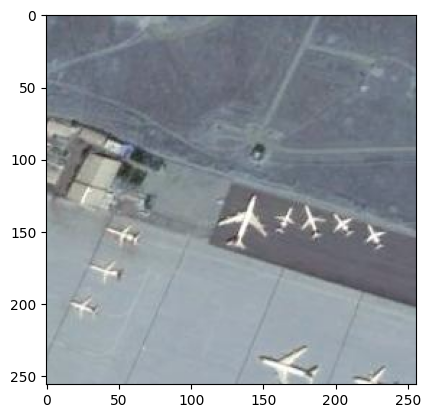

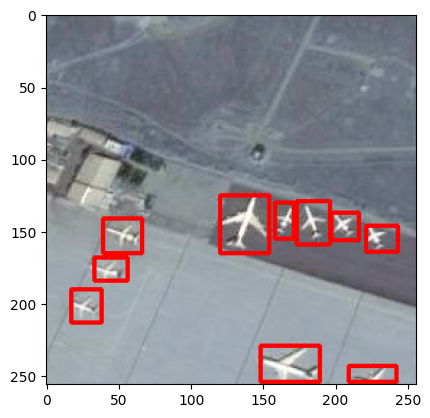

In [32]:
Index=20
filename = "airplane_0"+str(Index)+".jpg"
print(filename)
img = cv2.imread(os.path.join(path,filename))
df = pd.read_csv(os.path.join(annot,filename.replace(".jpg",".csv")))
plt.imshow(img)
for row in df.iterrows():
    x1 = int(float(row[1][0].split(" ")[0]))
    y1 = int(float(row[1][0].split(" ")[1]))
    x2 = int(float(row[1][0].split(" ")[2]))
    y2 = int(float(row[1][0].split(" ")[3]))
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.figure()
plt.imshow(img)

In [8]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

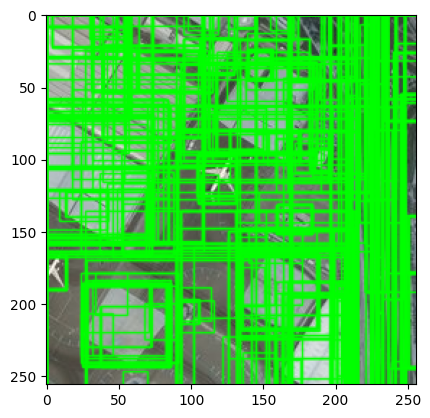

In [9]:
#generation of region proposals using selective search algorithms
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [10]:
#gets intersection over union
def get_iou(bb1, bb2):
  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [11]:
# At the end of below code we will have our train data in these lists
train_images=[]
train_labels=[]

In [12]:

for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)   # setting given image as base image
            ss.switchToSelectiveSearchFast()     # running selective search on bae image
            ssresults = ss.process()     # processing to get the outputs
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:     # till 2000 to get top 2000 regions only
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})  # calculating IoU for each of the proposed regions
                        if counter < 10:       # getting only 30 psoitive examples
                            if iou > 0.80:     # IoU or being positive is 0.7
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1              # to insure we have collected all psotive examples
                        if falsecounter <10:      # 30 negatve examples are allowed only
                            if iou < 0.2:         # IoU or being negative is 0.3
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1             #to ensure we have collected all negative examples
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1        # to signal the complition of data extaction from a particular image
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_289.jpg
inside
1 airplane_018.jpg
2 airplane_087.jpg
3 airplane_444.jpg
4 airplane_546.jpg
5 airplane_108.jpg
inside
6 airplane_163.jpg
7 airplane_463.jpg
8 airplane_649.jpg
9 airplane_068.jpg
10 airplane_447.jpg
11 airplane_528.jpg
12 airplane_579.jpg
13 airplane_490.jpg
inside
14 airplane_092.jpg
15 airplane_287.jpg
16 airplane_181.jpg
18 airplane_449.jpg
inside
19 airplane_383.jpg
inside
20 airplane_462.jpg
inside
21 airplane_139.jpg
22 airplane_069.jpg
23 airplane_596.jpg
24 airplane_114.jpg
25 airplane_392.jpg
inside
26 airplane_610.jpg
27 airplane_390.jpg
28 airplane_103.jpg
29 airplane_005.jpg
inside
31 airplane_472.jpg
32 airplane_179.jpg
inside
33 airplane_632.jpg
34 airplane_039.jpg
35 airplane_333.jpg
36 airplane_191.jpg
37 airplane_226.jpg
38 airplane_320.jpg
39 airplane_464.jpg
40 airplane_190.jpg
inside
41 airplane_294.jpg
42 airplane_474.jpg
43 airplane_510.jpg
44 airplane_292.jpg
45 airplane_091.jpg
46 airplane_344.jpg
47 airplane_544.jpg
48 airplane_592.jpg


In [13]:
X_new = np.array(train_images)
Y_new = np.array(train_labels)

In [14]:
# from keras.layers import Dense, GlobalAveragePooling2D
# from keras.models import Model
# from keras.applications.mobilenet_v2 import MobileNetV2
# from keras.optimizers import Adam
# from keras.preprocessing.image import ImageDataGenerator

# # Load the MobileNetV2 model with pre-trained weights and exclude the top layers
# base_model = MobileNetV2(weights='imagenet', include_top=False)
X_new

array([[[[139, 145, 150],
         [139, 145, 150],
         [139, 145, 150],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[139, 145, 150],
         [139, 145, 150],
         [139, 145, 150],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[139, 145, 150],
         [139, 145, 150],
         [139, 145, 150],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[123, 128, 129],
         [123, 128, 129],
         [123, 128, 129],
         ...,
         [119, 124, 123],
         [119, 124, 123],
         [119, 124, 123]],

        [[123, 128, 129],
         [123, 128, 129],
         [123, 128, 129],
         ...,
         [119, 124, 123],
         [119, 124, 123],
         [119, 124, 123]],

        [[123, 128, 129],
         [123, 128, 129],
         [123, 128, 129],
         ...,
         [119, 124, 123],
        

In [15]:
# import tensorflow as tf

# # Load the MobileNetV2 model with weights pre-trained on ImageNet
# mobilenet_v2 = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# # Freeze all layers in the MobileNetV2 model
# for layer in mobilenet_v2.layers:
#     layer.trainable = False

# # Add custom layers on top of the MobileNetV2 model
# x = mobilenet_v2.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)  # Add dropout to reduce overfitting
# x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# # Create the final model
# model = tf.keras.Model(inputs=mobilenet_v2.input, outputs=x)

# # Compile the model
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# # Print the model summary
# model.summary()
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.applications.nasnet import NASNetMobile
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Load the NASNetMobile model with pre-trained weights and exclude the top layers
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting
x = Dense(1, activation='sigmoid')(x)  # Assuming binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()




19993432/19993432 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     

In [16]:
# model.summary()
model.fit(X_new, Y_new, batch_size=16, epochs=3, verbose=1, validation_split=0.05, shuffle=True)

Epoch 1/3
612/612 [==============================] - 831s 1s/step - loss: 0.9628 - accuracy: 0.6490 - val_loss: 0.5936 - val_accuracy: 0.7301
Epoch 2/3
612/612 [==============================] - 805s 1s/step - loss: 0.6001 - accuracy: 0.6938 - val_loss: 0.5784 - val_accuracy: 0.7068
Epoch 3/3
612/612 [==============================] - 802s 1s/step - loss: 0.5885 - accuracy: 0.7075 - val_loss: 0.5709 - val_accuracy: 0.7223


In [17]:
svm_image = [];
svm_label = [];

In [18]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
                timage = image[x1:x2,y1:y2]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                svm_image.append(resized)
                svm_label.append([0,1])
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if falsecounter <5:
                            if iou < 0.3:
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                svm_image.append(resized)
                                svm_label.append([1,0])
                                falsecounter += 1
                        else :
                            flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_289.jpg
1 airplane_018.jpg
2 airplane_087.jpg
3 airplane_444.jpg
4 airplane_546.jpg
5 airplane_108.jpg
6 airplane_163.jpg
7 airplane_463.jpg
8 airplane_649.jpg
9 airplane_068.jpg
10 airplane_447.jpg
11 airplane_528.jpg
12 airplane_579.jpg
13 airplane_490.jpg
14 airplane_092.jpg
15 airplane_287.jpg
16 airplane_181.jpg
18 airplane_449.jpg
19 airplane_383.jpg
20 airplane_462.jpg
21 airplane_139.jpg
22 airplane_069.jpg
23 airplane_596.jpg
24 airplane_114.jpg
25 airplane_392.jpg
26 airplane_610.jpg
27 airplane_390.jpg
28 airplane_103.jpg
29 airplane_005.jpg
31 airplane_472.jpg
32 airplane_179.jpg
33 airplane_632.jpg
34 airplane_039.jpg
35 airplane_333.jpg
36 airplane_191.jpg
37 airplane_226.jpg
38 airplane_320.jpg
39 airplane_464.jpg
40 airplane_190.jpg
41 airplane_294.jpg
42 airplane_474.jpg
43 airplane_510.jpg
44 airplane_292.jpg
45 airplane_091.jpg
46 airplane_344.jpg
47 airplane_544.jpg
48 airplane_592.jpg
49 airplane_690.jpg
50 airplane_394.jpg
51 airplane_691.jpg
52 airplan

In [21]:

#adding svm to last layer
x =model.get_layer('dense_1').output
Y = tf.keras.layers.Dense(2)(x)
final_model = tf.keras.Model(model.input,Y)
final_model.compile(loss='hinge',
              optimizer='adam',
              metrics=['accuracy'])
final_model.summary()
#final_model.load_weights('my_model_weights.h5')

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv1 (Conv2D)         (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn1 (BatchNormalizati  (None, 111, 111, 32)         128       ['stem_conv1[0][0]']          
 on)                                                                                              
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['stem_bn1[0][0]']      

In [23]:
hist_final = final_model.fit(np.array(svm_image),np.array(svm_label),batch_size=15,epochs = 2,verbose = 1,shuffle = True,validation_split = 0.05)

Epoch 1/2
356/356 [==============================] - 453s 1s/step - loss: 0.8642 - accuracy: 0.6243 - val_loss: 0.9538 - val_accuracy: 0.5338
Epoch 2/2
356/356 [==============================] - 452s 1s/step - loss: 0.7961 - accuracy: 0.6256 - val_loss: 0.9364 - val_accuracy: 0.5338


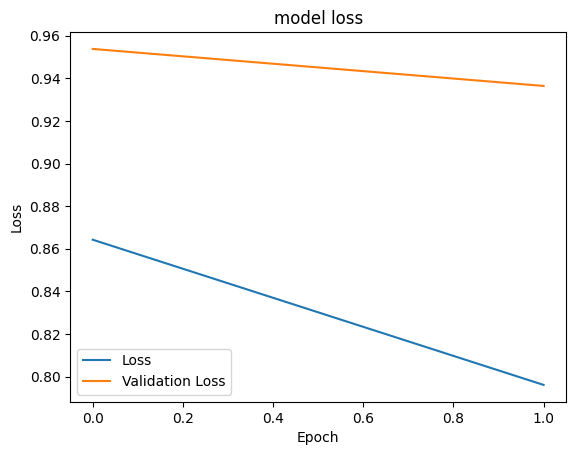

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist_final.history['loss'])
plt.plot(hist_final.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

1/1 [==============================] - 0s 278ms/step
0 [[ 0.9419355  -0.94311804]]
1/1 [==============================] - 0s 326ms/step
1 [[ 0.9419355  -0.94311804]]
1/1 [==============================] - 1s 594ms/step
2 [[ 0.9419355  -0.94311804]]
1/1 [==============================] - 0s 390ms/step
3 [[ 0.9419355  -0.94311804]]
1/1 [==============================] - 0s 229ms/step
4 [[ 0.9419355  -0.94311804]]
1/1 [==============================] - 0s 111ms/step
5 [[ 0.9419355  -0.94311804]]
1/1 [==============================] - 0s 149ms/step
6 [[ 0.9419355  -0.94311804]]
1/1 [==============================] - 0s 111ms/step
7 [[ 0.9419355  -0.94311804]]
1/1 [==============================] - 0s 117ms/step
8 [[ 0.9419355  -0.94311804]]
1/1 [==============================] - 0s 112ms/step
9 [[ 0.9419355  -0.94311804]]
1/1 [==============================] - 0s 116ms/step
10 [[ 0.9419355  -0.94311804]]
1/1 [==============================] - 0s 110ms/step
11 [[ 0.9419355  -0.94311804]]
1/

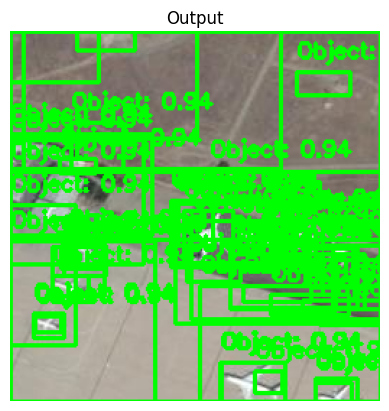

In [36]:
image = cv2.imread(os.path.join(path,'airplane_020.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
count = 0

# Loop through the selective search results
for e, result in enumerate(ssresults):
    if e < 50:  # Limit to the top 50 results
        x, y, w, h = result
        timage = imOut[y:y+h, x:x+w]  # Correct slicing order to (y, y+h, x, x+w)
        resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
        resized = np.expand_dims(resized, axis=0)
        out = final_model.predict(resized)
        print(e, out)

        # Define a threshold to consider a region as a valid detection
        if out[0][0] > 0.94:  # Assuming a threshold of 0.5 for binary classification
            boxes.append(result)
            count += 1
            # Draw the rectangle on the output image
            cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 2)
            # Optionally add a label
            label = 'Object: {:.2f}'.format(out[0][0])
            cv2.putText(imOut, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert BGR image to RGB for display with matplotlib
imOut = cv2.cvtColor(imOut, cv2.COLOR_BGR2RGB)

# Show the final output image with detected regions using matplotlib
plt.imshow(imOut)
plt.title('Output')
plt.axis('off')
plt.show()